# **Data Collection**

## Objectives

* Fetch the image classification dataset CIFAR-10 from Kaggle and save it as raw data.
* Inspect the image data.
* Split into train, test and validation sets.

## Inputs
Write here which data or information you need to run the notebook 
* [https://www.kaggle.com/competitions/cifar-10/overview](https://www.kaggle.com/competitions/cifar-10/overview)
* Kaggle JSON file for authentication.

## Outputs
output/train/
output/test/
output/trainLabels.csv

## Overview
Problem The e-commerce platform aims to improve its product categorization by developing a machine learning model that can classify images into one of 10 categories with high accuracy. To prototype this solution, the company will use a subset of the CIFAR-10 dataset, which contains a large number of images, to ensure compatibility with deployment constraints on platforms like Heroku and GitHub.

**Data:**

- Training Data: The CIFAR-10 dataset originally includes 50,000 images across 10 categories. For this project, a reduced subset will be used to fit within the storage and performance limits of Heroku and GitHub. Specifically, the dataset will be trimmed to a smaller number of images per category to streamline processing.

- Testing Data: The CIFAR-10 dataset includes 10,000 images for testing. Similarly, this set will be reduced to ensure it is manageable within the deployment constraints. The reduced test set will be used to evaluate the model's performance and accuracy.

**Important Notes:**
- Dataset Adjustment: To make the dataset compatible with deployment constraints, a subset of images from both the training and testing sets will be selected. This will involve removing a portion of the images while retaining a representative sample of each category.

- Evaluation: Despite the reduced dataset, the goal remains to achieve high accuracy in classifying images into the correct categories. The adjusted training and testing sets will be used to develop and assess the model’s performance effectively.

**Quick Recap:**
- /train - A smaller subset of 3500 images of the original 50,000 images from the training set.
- /test - A smaller of subset 1000 images of the subset of the original 50.000 images from the training set.
- /validation - A smaller subset of 500 images of the original 50.000 images from the training set.
- trainLabels.csv/ - The CIFAR-10 dataset’s 10 predefined categories will still be used, but with a reduced number of images to fit deployment constraints.

This adjusted approach ensures that the model can be developed, tested, and deployed efficiently while meeting the project’s business requirements.

## Additional Comments TBC
* 290,000 junk images in the test set.
* Trivial modifications to the official 10,000 test images to prevent looking them up by file hash.
* **We have only used the train set and divided these images into test, train and validation sets to limit the size of the dataset**


---

# Install 
Install requirements, import libraries, and set variable DatasetFolder

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install opencv-python pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# import tensorflow as tf
import zipfile
import py7zr
import shutil
import random
import joblib


# Change working directory

Change working directory to root project folder

In [4]:
current_dir = os.getcwd()
print('Current folder: ' + current_dir)
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('New folder: ' + current_dir)

Current folder: /workspace/SnapSortAI/jupyter_notebooks
New folder: /workspace/SnapSortAI


---

# Fetch Data from Kaggle and Extract Files

* Install Kaggle, configure the directory, and set permissions for the Kaggle authentication JSON.
* Download the Kaggle dataset.
* Unzip the file, extract .7z files and delete the unused files and kaggle.json

In [5]:
%pip install kaggle==1.5.12
print('Requirements installed.')

os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json
print('Directory configured and permissions set.')

DatasetFolder = 'inputs/cifar10_dataset_small'

! kaggle competitions download -c cifar-10 -p {DatasetFolder}

# Extract ZIP file
zip_file_path = os.path.join(DatasetFolder, 'cifar-10.zip')
if os.path.exists(zip_file_path):
    print('Extracting ZIP file...')
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(DatasetFolder)
    print('ZIP file extraction complete.')
else:
    print(f"File {zip_file_path} not found.")

# Extract train.7z file
train_7z_path = os.path.join(DatasetFolder, 'train.7z')
if os.path.exists(train_7z_path):
    print('Extracting train.7z set...')
    with py7zr.SevenZipFile(train_7z_path, 'r') as archive:
        archive.extractall(DatasetFolder)
    print('train.7z extracted.')
else:
    print(f"File {train_7z_path} not found.")

# Delete original files after successful extraction
files_to_remove = [
    os.path.join(DatasetFolder, 'cifar-10.zip'),
    os.path.join(DatasetFolder, 'test.7z'),
    os.path.join(DatasetFolder, 'train.7z'),
    os.path.join(DatasetFolder, 'sampleSubmission.csv')
]
for file_path in files_to_remove:
    try:
        os.remove(file_path)
        print(f"Removed {file_path}")
    except Exception as e:
        print(f"Error removing {file_path}: {str(e)}")

print('Unused files deleted.')


Note: you may need to restart the kernel to use updated packages.
Requirements installed.
Directory configured and permissions set.
100%|███████████████████████████████████████▊| 712M/715M [00:20<00:00, 37.7MB/s]
100%|████████████████████████████████████████| 715M/715M [00:20<00:00, 36.4MB/s]
Extracting ZIP file...
ZIP file extraction complete.
Extracting train.7z set...
train.7z extracted.
Removed inputs/cifar10_dataset_small/cifar-10.zip
Removed inputs/cifar10_dataset_small/test.7z
Removed inputs/cifar10_dataset_small/train.7z
Removed inputs/cifar10_dataset_small/sampleSubmission.csv
Unused files deleted.


## Divide Images Into Respective Class Directories

* We are sampling 500 images per class for this project.

In [6]:
import csv


def load_filename_to_class_map(csv_file_path):
    """
    Load a mapping from a CSV file that contains image filenames and their corresponding classes.
    
    Args:
        csv_file_path (str): Path to the CSV file.
        
    Returns:
        dict: A dictionary mapping filenames to class names.
    """
    filename_to_class_map = {}
    
    with open(csv_file_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            filename = row['id'] + '.png'  # CSV has an 'id' column for image number
            label = row['label']           # CSV has a 'label' column for class name
            filename_to_class_map[filename] = label
    
    return filename_to_class_map

def split_images(dataset_root_dir, classes, filename_to_class_map, total_samples=500):
    """
    Splits images from the source directory into class-specific directories,
    ensuring each class has exactly 500 images.

    Args:
        dataset_root_dir (str): Path to the dataset directory.
        classes (list): List of class names to split (e.g., ['airplane', 'automobile', 'bird', ...]).
        filename_to_class_map (dict): Dictionary mapping filenames to class names.
        total_samples (int): Number of images to sample for each class (default is 500).
    """
    # Source directory
    source_dir = os.path.join(dataset_root_dir, 'train')

    if not os.path.exists(source_dir):
        print(f"Source directory {source_dir} does not exist!")
        return

    # Create class-specific directories within dataset_root_dir
    for cls in classes:
        class_dir = os.path.join(dataset_root_dir, cls)
        os.makedirs(class_dir, exist_ok=True)
        print(f"Created class folder: {class_dir}")  

    # Organize files by class
    class_files = {cls: [] for cls in classes}
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.png'):
            cls = filename_to_class_map.get(file_name)
            if cls:
                file_path = os.path.join(source_dir, file_name)
                class_files[cls].append(file_path)

    # Calculate the number of samples per class
    samples_per_class = min(total_samples, len(class_files[classes[0]]))

    # Randomly sample images for each class and move them to their respective folders
    for cls, files in class_files.items():
        selected_files = random.sample(files, samples_per_class)
        for file_path in selected_files:
            dest_path = os.path.join(dataset_root_dir, cls, os.path.basename(file_path))
            try:
                shutil.move(file_path, dest_path)
            except Exception as e:
                print(f"Error moving file {file_path} to {dest_path}: {str(e)}")

    # Delete the original train directory after moving all files
    try:
        shutil.rmtree(source_dir)
        print("\nOriginal train directory deleted successfully.")
    except Exception as e:
        print(f"\nError deleting original train directory: {str(e)}")

    # Print when the process is done
    print("\nAll files have been moved to their respective class folders.")

# Load the filename to class map
csv_file_path = 'inputs/cifar10_dataset_small/trainLabels.csv'
filename_to_class_map = load_filename_to_class_map(csv_file_path)

# Class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


dataset_root_dir = 'inputs/cifar10_dataset_small'

# Call the function to split images
split_images(dataset_root_dir=dataset_root_dir, classes=classes, filename_to_class_map=filename_to_class_map, total_samples=500)


Created class folder: inputs/cifar10_dataset_small/airplane
Created class folder: inputs/cifar10_dataset_small/automobile
Created class folder: inputs/cifar10_dataset_small/bird
Created class folder: inputs/cifar10_dataset_small/cat
Created class folder: inputs/cifar10_dataset_small/deer
Created class folder: inputs/cifar10_dataset_small/dog
Created class folder: inputs/cifar10_dataset_small/frog
Created class folder: inputs/cifar10_dataset_small/horse
Created class folder: inputs/cifar10_dataset_small/ship
Created class folder: inputs/cifar10_dataset_small/truck

Original train directory deleted successfully.

All files have been moved to their respective class folders.


### Clean Up - Remove Non-Images from Class Directories

In [7]:

def remove_non_image_file(dataset_root_dir):
    """
    Removes non-image files from the dataset directory, ensuring only image files remain.
    
    Args:
        dataset_root_dir (str): The root directory containing subdirectories of image classes.
    """
    # Define valid image extensions
    image_extensions = ('.png', '.jpg', '.jpeg')  

    # List all subdirectories inside the dataset root
    folders = os.listdir(dataset_root_dir)

    for folder in folders:
        folder_path = os.path.join(dataset_root_dir, folder)

        # Only process directories (skipping any files at the root)
        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)

            image_count = 0
            non_image_count = 0

            for given_file in files:
                file_path = os.path.join(folder_path, given_file)

                # Check if file doesn't have a valid image extension
                if not given_file.lower().endswith(image_extensions):
                    # Remove non-image file
                    os.remove(file_path)
                    non_image_count += 1
                else:
                    image_count += 1

            # Report the number of images and non-images in the folder
            print(f"Folder: {folder} - contains {image_count} image files")
            print(f"Folder: {folder} - removed {non_image_count} non-image files")

remove_non_image_file(dataset_root_dir)


Folder: airplane - contains 500 image files
Folder: airplane - removed 0 non-image files
Folder: automobile - contains 500 image files
Folder: automobile - removed 0 non-image files
Folder: bird - contains 500 image files
Folder: bird - removed 0 non-image files
Folder: cat - contains 500 image files
Folder: cat - removed 0 non-image files
Folder: deer - contains 500 image files
Folder: deer - removed 0 non-image files
Folder: dog - contains 500 image files
Folder: dog - removed 0 non-image files
Folder: frog - contains 500 image files
Folder: frog - removed 0 non-image files
Folder: horse - contains 500 image files
Folder: horse - removed 0 non-image files
Folder: ship - contains 500 image files
Folder: ship - removed 0 non-image files
Folder: truck - contains 500 image files
Folder: truck - removed 0 non-image files


## Inspect the First 10 Labels Available in the trainLabels.csv file:

In [8]:
df = pd.read_csv(f"{dataset_root_dir}/trainLabels.csv")
df.head(10)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


By checking our DataFrame, we can see that:

* There are 10 unique labels.
* We noticed Labels is a categorical variables. We will replace/convert it to an integer as the ML model requires numeric variables.
* The CSV file can act as a complete record of all the original labels and their corresponding image IDs, so we keep that file untouched.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   label   50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [10]:
df['label'].unique()

array(['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship',
       'cat', 'dog', 'airplane'], dtype=object)

* Checking that the class directories includes 500 images each:

In [13]:
class_folders = os.listdir(dataset_root_dir)

# Iterate through each class folder
for class_folder in class_folders:
    class_folder_path = os.path.join(dataset_root_dir, class_folder)
    
    # Check if the class folder path exists and is a directory
    if os.path.exists(class_folder_path) and os.path.isdir(class_folder_path):
        # List all files in the class folder
        files = os.listdir(class_folder_path)
        print(f"Total number of files in '{class_folder}': {len(files)}")
    else:
        print(f"The path {class_folder_path} does not exist or is not a directory.")

The path inputs/cifar10_dataset_small/trainLabels.csv does not exist or is not a directory.
Total number of files in 'airplane': 500
Total number of files in 'automobile': 500
Total number of files in 'bird': 500
Total number of files in 'cat': 500
Total number of files in 'deer': 500
Total number of files in 'dog': 500
Total number of files in 'frog': 500
Total number of files in 'horse': 500
Total number of files in 'ship': 500
Total number of files in 'truck': 500


# Split Dataset 

* Split dataset into train (70%), validation (10%) and test (20%) sets

In [14]:
def split_train_validation_test_images(dataset_root_dir, train_ratio=0.7, validation_ratio=0.1, test_ratio=0.2):
    """
    Splits dataset into train, validation, and test sets, and moves images into respective folders.
    
    Args:
        dataset_root_dir (str): Root directory containing class folders with images.
        train_ratio (float): Ratio of the dataset to be used for training.
        validation_ratio (float): Ratio of the dataset to be used for validation.
        test_ratio (float): Ratio of the dataset to be used for testing.
    """
    # Check if the sum of ratios is equal to 1.0
    if train_ratio + validation_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, validation_ratio, and test_ratio should equal 1.0.")
    
    # List class directories (subfolders)
    classes = [folder for folder in os.listdir(dataset_root_dir) if os.path.isdir(os.path.join(dataset_root_dir, folder)) 
               and folder not in ['train', 'validation', 'test']]
    
    for split in ['train', 'validation', 'test']:
        # Create train, validation, and test directories if they don't exist
        split_dir = os.path.join(dataset_root_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for class_name in classes:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

    for class_name in classes:
        # Get the list of all images for this class
        class_dir = os.path.join(dataset_root_dir, class_name)
        images = os.listdir(class_dir)

        # Shuffle images randomly
        random.shuffle(images)
        
        # Calculate number of images for each split
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        validation_count = int(total_images * validation_ratio)
        test_count = total_images - train_count - validation_count  # Remaining goes to test

        # Split into training, validation, and test sets
        train_set = images[:train_count]
        validation_set = images[train_count:train_count + validation_count]
        test_set = images[train_count + validation_count:]
        
        # Move images to the respective directories
        for image in train_set:
            shutil.move(os.path.join(class_dir, image), os.path.join(dataset_root_dir, 'train', class_name, image))
        for image in validation_set:
            shutil.move(os.path.join(class_dir, image), os.path.join(dataset_root_dir, 'validation', class_name, image))
        for image in test_set:
            shutil.move(os.path.join(class_dir, image), os.path.join(dataset_root_dir, 'test', class_name, image))

        print(f"Class '{class_name}' -> Train: {len(train_set)}, Validation: {len(validation_set)}, Test: {len(test_set)}")

    # Remove the original class directories if all images are moved
    for class_name in classes:
        class_dir = os.path.join(dataset_root_dir, class_name)
        if os.path.exists(class_dir) and os.path.isdir(class_dir):
            try:
                shutil.rmtree(class_dir)
            except Exception as e:
                print(f"Error removing directory {class_dir}: {e}")

split_train_validation_test_images(dataset_root_dir, train_ratio=0.7, validation_ratio=0.1, test_ratio=0.2)


Class 'airplane' -> Train: 350, Validation: 50, Test: 100
Class 'automobile' -> Train: 350, Validation: 50, Test: 100
Class 'bird' -> Train: 350, Validation: 50, Test: 100
Class 'cat' -> Train: 350, Validation: 50, Test: 100
Class 'deer' -> Train: 350, Validation: 50, Test: 100
Class 'dog' -> Train: 350, Validation: 50, Test: 100
Class 'frog' -> Train: 350, Validation: 50, Test: 100
Class 'horse' -> Train: 350, Validation: 50, Test: 100
Class 'ship' -> Train: 350, Validation: 50, Test: 100
Class 'truck' -> Train: 350, Validation: 50, Test: 100


# Load and Inspect Image Data

In [15]:
%pip install pillow

Note: you may need to restart the kernel to use updated packages.


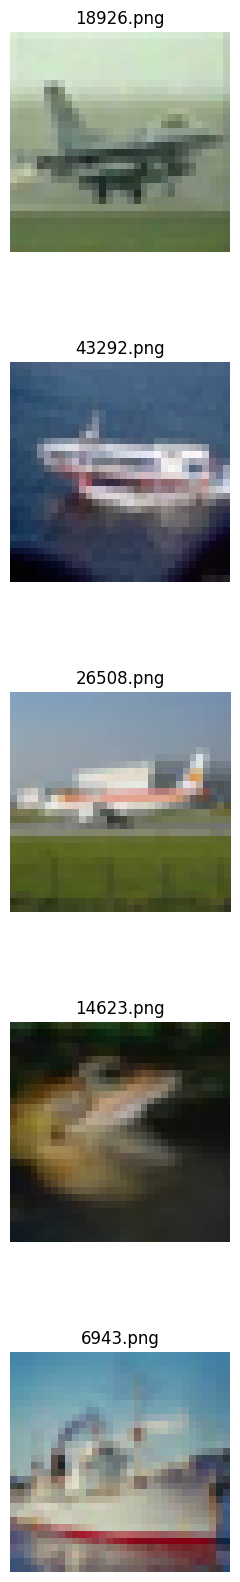

In [16]:
from PIL import Image

def display_images(dataset_dir, num_images=5):
    """
    Displays a specified number of random images from the given directory and its subdirectories.
    
    Args:
        dataset_dir (str): Path to the directory containing class subdirectories with images.
        num_images (int): Number of images to display.
    """
    # Check if the directory exists
    if not os.path.exists(dataset_dir):
        print(f"Error: The directory '{dataset_dir}' does not exist.")
        return

    # List class subdirectories
    classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    
    # Empty list to store image paths
    image_paths = []
    
    # Collect image paths from each class subdirectory
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        
        # Add image paths to the list
        for file in files:
            image_paths.append(os.path.join(class_dir, file))
    
    # Shuffle the image paths
    random.shuffle(image_paths)
    
    # Create subplots dynamically based on the number of images
    if num_images > 1:
        fig, axes = plt.subplots(num_images, 1, figsize=(10, 4 * num_images))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 4))
        axes = [axes]  # Make axes iterable if there's only one subplot
    
    for i, img_path in enumerate(image_paths[:num_images]):
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(img_path))
            axes[i].axis('off')
        except Exception as e:
            print(f"Warning: {os.path.basename(img_path)} could not be read. Error: {e}")
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

train_folder = os.path.join(dataset_root_dir, 'train')

display_images(train_folder, num_images=5)


# Copy random images from each class to output folder

In [18]:
def copy_random_images(number_per_class, dataset_root_dir, output_folder, classes):
    """
    Copies a specified number of random images from each class in the CIFAR-10 dataset 
    to a specified output folder.
    
    Args:
        number_per_class (int): Number of images to sample from each class.
        dataset_root_dir (str): Path to the CIFAR-10 dataset folder.
        output_folder (str): Path to the output folder where sampled images will be stored.
        classes (list): List of class names in the dataset.
    """
    
    # Define the validation set directory
    validation_dir = os.path.join(dataset_root_dir, 'validation')
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    for class_name in classes:
        # Create the sample directory for the current class
        sample_class_dir = os.path.join(output_folder, class_name)
        os.makedirs(sample_class_dir, exist_ok=True)

        # Define the class directory in the validation set
        class_dir = os.path.join(validation_dir, class_name)
        
        # Print paths for debugging
        print(f"Checking class directory: {class_dir}")

        # Check if class directory exists
        if not os.path.exists(class_dir):
            print(f"Warning: Directory for class '{class_name}' does not exist at {class_dir}.")
            continue

        # Get a list of all images in the class directory
        all_images = os.listdir(class_dir)

        # Ensure we do not sample more images than available
        if len(all_images) < number_per_class:
            print(f"Warning: Not enough images in class '{class_name}' to sample {number_per_class} images. Sampling all available images.")
            number_per_class = len(all_images)
        
        # Select a number of random images from each class
        random_images = random.sample(all_images, number_per_class)

        # Copy the selected images to the sample directories
        for image in random_images:
            src_image_path = os.path.join(class_dir, image)
            dest_image_path = os.path.join(sample_class_dir, image)
            shutil.copy(src_image_path, dest_image_path)

    print("Sampling completed.")


output_folder = 'outputs/sample_images'

copy_random_images(5, dataset_root_dir, output_folder, classes)

Checking class directory: inputs/cifar10_dataset_small/validation/airplane
Checking class directory: inputs/cifar10_dataset_small/validation/automobile
Checking class directory: inputs/cifar10_dataset_small/validation/bird
Checking class directory: inputs/cifar10_dataset_small/validation/cat
Checking class directory: inputs/cifar10_dataset_small/validation/deer
Checking class directory: inputs/cifar10_dataset_small/validation/dog
Checking class directory: inputs/cifar10_dataset_small/validation/frog
Checking class directory: inputs/cifar10_dataset_small/validation/horse
Checking class directory: inputs/cifar10_dataset_small/validation/ship
Checking class directory: inputs/cifar10_dataset_small/validation/truck
Sampling completed.


## Create a ZIP File of the Sampled Images

In [20]:
def compress_folder_to_zip(folder_path, zip_filename="sample_images.zip"):
    zip_path = os.path.join(os.path.dirname(folder_path), zip_filename)

    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

    return zip_path


OutputFolder = 'outputs/sample_images'
compress_folder_to_zip(OutputFolder)

'outputs/sample_images.zip'

---

# Conclusions And Next Steps

This initial configuration prepares the files.
By downloading the files and setting them up in the right directories we can directly access them. 
By loading the labels and images we were able to see that we are dealing with 10 different objects.

The next notebook includes Data Visualization:

**1. Visualize Dataset Overview:**
* Create plots to show the distribution of images across different classes.
* Generate a few sample images from each class to confirm the dataset’s diversity and balance.

**2. Explore Data Distribution:**
* Plot histograms or bar charts to visualize the number of images in each class.
* Use pie charts or bar plots to display the distribution of classes in the dataset.

---

# Push files to Repo

* Data collection and cleaning has finished. You can push the files to the GitHub repository and close this notebook.